# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.dates import DateFormatter

import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf

# 1. Data Cleaning

## Prepare dataset

In [2]:
# Reading the given dataset
df = pd.read_excel("010224 Carbon Data Analyst Case Study Utility Dataset vS.xlsx")
df

,Property,Unit,Meter_ID,Start_Date,End_Date,Electricity_Usage_kWh,Gas_Usage_Therms,Water_Usage_Gallons,Square_Footage
0,One World Trade Center,Condé Nast,ONE-CON-01,2017-01-01,2017-01-28,5866.991754,1966.266006,113007.635507,925000.0
1,One World Trade Center,Condé Nast,ONE-CON-01,2017-01-01,2017-01-28,6484.184022,2602.786950,107781.967288,925000.0
2,Empire State Building,Expedia,EMP-EXP-01,2017-01-01,2017-01-28,4709.977548,2019.855043,83490.222657,673000.0
3,Empire State Building,Shutterstock,EMP-SHU-01,2017-01-01,2017-01-28,NaN,2189.101181,78615.698161,784000.0
4,Empire State Building,Airbnb,EMP-AIR-01,2017-01-01,2017-01-28,5168.459204,2477.125734,92244.413919,524000.0
...,...,...,...,...,...,...,...,...,...
527,One World Trade Center,Condé Nast,ONE-CON-01,2021-12-21,2021-12-31,6993.190134,2380.830574,100426.312038,925000.0
528,One World Trade Center,Durst Organization,ONE-DUR-01,2021-12-21,2021-12-31,5246.824207,2227.114608,110775.174656,1752000.0
529,One World Trade Center,Spotify,ONE-SPO-01,2021-12-21,2021-12-31,5526.998677,2219.696208,127535.631943,823000.0
530,Empire State Building,Airbnb,EMP-AIR-01,2021-12-21,2021-12-31,5277.430218,2107.973883,88659.645837,524000.0


First thing I recognize is that Condé Nast (as well as LinkedIn) have 2 identical Property, Unit, Meter_ID, Start_Date, End_Date, and Square_Footage, but with different Utility meter measurements. If this were a real scenario, I first would verify which numbers are correct. In this case study, I will take the average of the two measurements.

It could be the case that there are two offices in the same building and are connected to the same meter (perhaps just on different floors), but this raises more questions. Looking at the sum of the two measurements gives a extremely large measurement that doesn't track with any of the other companies outputs. So unless the other large square footage companies underutilize its' office space, there would be no way that their output should be as high as it is.

In [3]:
# Creating a dictionary with keys of unique meter ids
ts_dfs = {meter: df[df['Meter_ID'] == meter].copy() for meter in df['Meter_ID'].unique()}
ts_dfs.keys()

dict_keys(['ONE-CON-01', 'EMP-EXP-01', 'EMP-SHU-01', 'EMP-AIR-01', 'EMP-LIN-01', 'ONE-DUR-01', 'ONE-SPO-01'])

## Get data into a clean database

In [4]:
# Split combined dataframe into their own dataframes
ts_con = ts_dfs['ONE-CON-01']
ts_exp = ts_dfs['EMP-EXP-01']
ts_shu = ts_dfs['EMP-SHU-01']
ts_air = ts_dfs['EMP-AIR-01']
ts_lin = ts_dfs['EMP-LIN-01']
ts_dur = ts_dfs['ONE-DUR-01']
ts_spo = ts_dfs['ONE-SPO-01']

In [5]:
# View snippet of split dataset
ts_con.head(3)

,Property,Unit,Meter_ID,Start_Date,End_Date,Electricity_Usage_kWh,Gas_Usage_Therms,Water_Usage_Gallons,Square_Footage
0,One World Trade Center,Condé Nast,ONE-CON-01,2017-01-01,2017-01-28,5866.991754,1966.266006,113007.635507,925000.0
1,One World Trade Center,Condé Nast,ONE-CON-01,2017-01-01,2017-01-28,6484.184022,2602.786950,107781.967288,925000.0
16,One World Trade Center,Condé Nast,ONE-CON-01,2017-01-29,2017-02-27,6709.920806,2409.546657,122961.274110,925000.0


When going through the timeseries list, we see that many companies have missing measurements during some months. To correct for this, we first go through an impute any missing values with the average between said missing point. This allows us to keep any linear trend or seasonality that may present itself. 

In the case of missing values on the beginning or end months, we back fill and forward fill any missing points. This is the only way to approximate the missing point since we cannot take the average in these cases.

In [6]:
# Set variables to clean up code
ts_list = [ts_con, ts_exp, ts_shu, ts_air, ts_lin, ts_dur, ts_spo]
met_list = ['Electricity_Usage_kWh', 'Gas_Usage_Therms', 'Water_Usage_Gallons']

# Go through and impute missing values and convert certain obj. to datetime
for ts in ts_list:
    for metric in met_list:
        # filling in missing values
        ts[metric]= ts[metric].interpolate(method='linear')
        ts[metric]= ts[metric].interpolate(method='bfill')
        ts[metric]= ts[metric].interpolate(method='ffill')

    # Convert Start Date and End Date to datetime format
    ts['End_Date'] = pd.to_datetime(ts['End_Date'])
    ts['Start_Date'] = pd.to_datetime(ts['Start_Date'])

For the two companies with the same Meter_ID but different utility measurements, we group them by the Meter_ID and the take the average of the two.

In [7]:
# Function that averages the measurements from the Meter_ID with two values
def comb_meter(df):
    df = df.groupby(['Property', 'Unit', 'Meter_ID', 'Start_Date', 'End_Date']).mean().reset_index()
    return df

In [8]:
# Average out any meters with conflicting reports on the same months
ts_con = comb_meter(ts_con)
ts_lin = comb_meter(ts_lin)

In [9]:
# View snippet of split dataset
ts_lin.head(3)

,Property,Unit,Meter_ID,Start_Date,End_Date,Electricity_Usage_kWh,Gas_Usage_Therms,Water_Usage_Gallons,Square_Footage
0,Empire State Building,LinkedIn,EMP-LIN-01,2017-01-01,2017-01-28,5358.717498,2355.664548,87100.663533,819000.0
1,Empire State Building,LinkedIn,EMP-LIN-01,2017-01-29,2017-02-27,4759.683811,2112.433499,90318.763256,819000.0
2,Empire State Building,LinkedIn,EMP-LIN-01,2017-02-28,2017-03-27,4772.505609,1978.701985,77601.798687,819000.0


Finally we export the dataset in an Excel file so that we maintain our datetime formate for our Start and End Dates.

This also marks the creation of our clean datasets.

In [10]:
# # Export data
# ts_con = ts_con.to_excel('ts_con.xlsx', index=False)
# ts_exp = ts_exp.to_excel('ts_exp.xlsx', index=False)
# ts_shu = ts_shu.to_excel('ts_shu.xlsx', index=False)
# ts_air = ts_air.to_excel('ts_air.xlsx', index=False)
# ts_lin = ts_lin.to_excel('ts_lin.xlsx', index=False)
# ts_dur = ts_dur.to_excel('ts_dur.xlsx', index=False)
# ts_spo = ts_spo.to_excel('ts_spo.xlsx', index=False)

# 2. Data Validation

## Evaluate data quality of utilities

In [11]:
# Reading our newly created single unit datasets
ts_con = pd.read_excel('ts_con.xlsx')
ts_exp = pd.read_excel('ts_exp.xlsx')
ts_shu = pd.read_excel('ts_shu.xlsx')
ts_air = pd.read_excel('ts_air.xlsx')
ts_lin = pd.read_excel('ts_lin.xlsx')
ts_dur = pd.read_excel('ts_dur.xlsx')
ts_spo = pd.read_excel('ts_spo.xlsx')

In [12]:
# Function that creates a Boxplot for each utility.
def box_plot(df):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Boxplot for Electricity Usage
    sns.boxplot(ax=axes[0], data=df['Electricity_Usage_kWh'], color='lightgreen')
    axes[0].set_title('Electricity Usage [kWh]')
    axes[0].set_ylabel('kWh')

    # Boxplot for Gas Usage
    sns.boxplot(ax=axes[1], data=df['Gas_Usage_Therms'], color='lightcoral')
    axes[1].set_title('Gas Usage [Therms]')
    axes[1].set_ylabel('Therms')

    # Boxplot for Water Usage
    sns.boxplot(ax=axes[2], data=df['Water_Usage_Gallons'], color='skyblue')
    axes[2].set_title('Water Usage [Gallons]')
    axes[2].set_ylabel('Gallons')
    
    plt.tight_layout()
    plt.show()

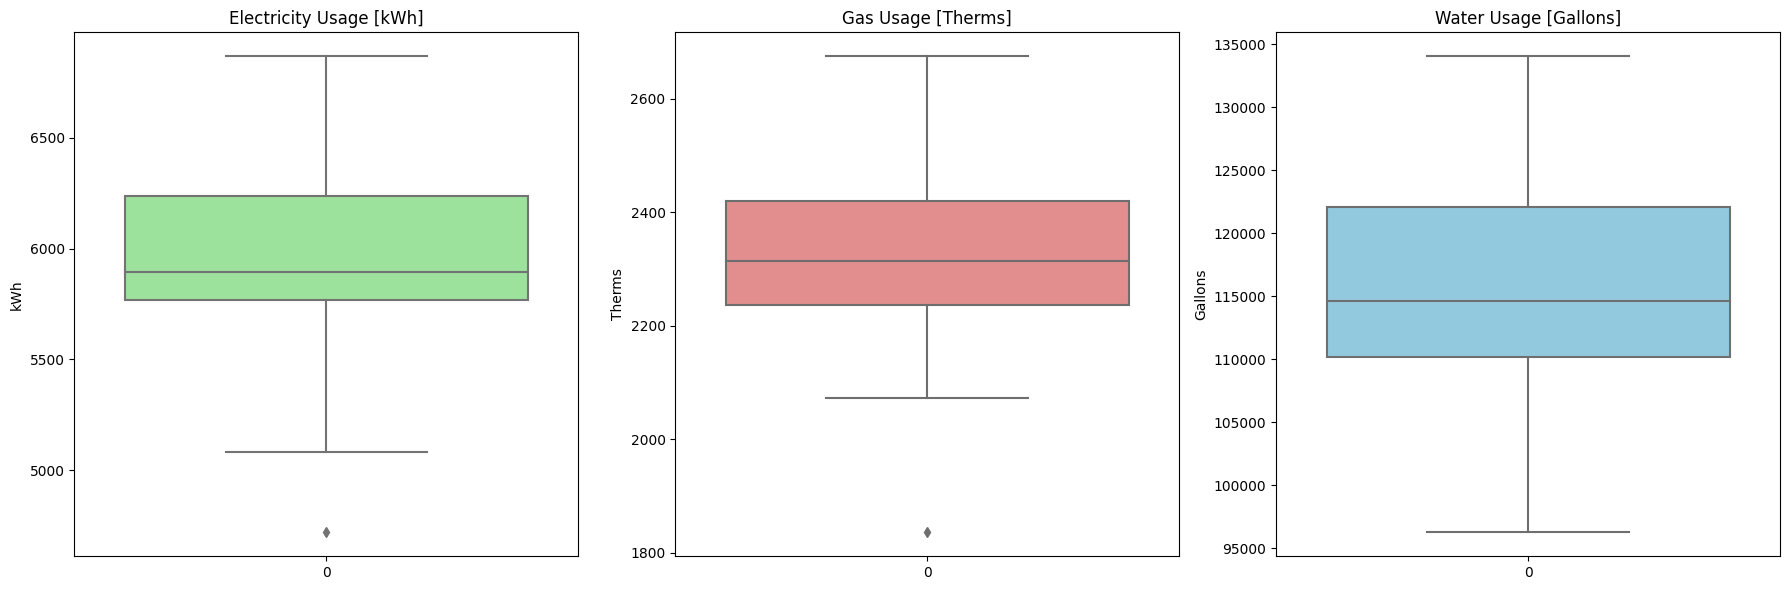

In [13]:
# Looking at different unit's Boxplot
box_plot(ts_con)

Looking at the boxplots for different companies we can see that there are some outliers in our data that should be explored.

## Normalize Data

In [14]:
# Function that creates new columns with normalized utility values
def normalize_data(df):
    # I've chosen the MinMaxScaler to normalize the data so it will be easier to compare utilities
    scaler = MinMaxScaler()
    df['Elec_norm'] = scaler.fit_transform(df['Electricity_Usage_kWh'].values.reshape(-1, 1))
    df['Gas_norm'] = scaler.fit_transform(df['Gas_Usage_Therms'].values.reshape(-1, 1))
    df['Water_norm'] = scaler.fit_transform(df['Water_Usage_Gallons'].values.reshape(-1, 1))
    return df

In [15]:
# Running the function on the datasets
ts_con = normalize_data(ts_con)
ts_exp = normalize_data(ts_exp)
ts_shu = normalize_data(ts_shu)
ts_air = normalize_data(ts_air)
ts_lin = normalize_data(ts_lin)
ts_dur = normalize_data(ts_dur)
ts_spo = normalize_data(ts_spo)

## Finding Outliers and Anomalies

### Outliers

In [16]:
# Function to calculate the outliers of Boxplot
def find_outliers(data, column):
    # Calculate the first and third quartile, IQR, and whiskers
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_whisker) | (data[column] > upper_whisker)]
    
    return outliers

In [17]:
# Set variables to clean up code
ts_list = [ts_con, ts_exp, ts_shu, ts_air, ts_lin, ts_dur, ts_spo]
met_list = ['Electricity_Usage_kWh', 'Gas_Usage_Therms', 'Water_Usage_Gallons']

In [18]:
# For loop that identifies outliers
for ts in ts_list:
    # Finding outliers
    outliers_electricity = find_outliers(ts, 'Electricity_Usage_kWh')
    outliers_gas = find_outliers(ts, 'Gas_Usage_Therms')
    outliers_water = find_outliers(ts, 'Water_Usage_Gallons')

    # Show outliers
    outliers_summary = {
        "Electricity Usage Outliers": outliers_electricity,
        "Gas Usage Outliers": outliers_gas,
        "Water Usage Outliers": outliers_water
    }

    print(outliers_summary)

{'Electricity Usage Outliers':                   Property        Unit    Meter_ID Start_Date   End_Date  \
32  One World Trade Center  Condé Nast  ONE-CON-01 2019-08-25 2019-09-22   

    Electricity_Usage_kWh  Gas_Usage_Therms  Water_Usage_Gallons  \
32            4718.738008       2267.365018        121073.126448   

    Square_Footage  Elec_norm  Gas_norm  Water_norm  
32          925000        0.0  0.514372     0.65681  , 'Gas Usage Outliers':                   Property        Unit    Meter_ID Start_Date   End_Date  \
11  One World Trade Center  Condé Nast  ONE-CON-01 2017-11-23 2017-12-23   

    Electricity_Usage_kWh  Gas_Usage_Therms  Water_Usage_Gallons  \
11             5765.08908       1836.007504         106682.46469   

    Square_Footage  Elec_norm  Gas_norm  Water_norm  
11          925000   0.486671       0.0    0.275973  , 'Water Usage Outliers': Empty DataFrame
Columns: [Property, Unit, Meter_ID, Start_Date, End_Date, Electricity_Usage_kWh, Gas_Usage_Therms, Water_Usag

As we can see there are multiple outliers either in the gas or electric measurements. There are both above and below the threshold of the box plot. Possible reasons for outliers to be below the Boxplot would be people out of office on vacation etc. Possible reasons for outlier to be above the Boxplot would be projects that required people to stay late and use more energy.

## Anomalies

In [19]:
# Function the detects anomalies - large percentage changes
def find_anomalies(df):
    # Creating columns for the absolute percentage change
    df['Electricity_Usage_Change'] = df['Electricity_Usage_kWh'].pct_change().abs().round(2) * 100
    df['Gas_Usage_Change'] = df['Gas_Usage_Therms'].pct_change().abs().round(2) * 100
    df['Water_Usage_Change'] = df['Water_Usage_Gallons'].pct_change().abs().round(2) * 100

    # Identifying potential anomalies - large percentage changes
    anomaly_threshold = 30  # 30% change from month to month - arbitrary number
    potential_anomalies = df[(df['Electricity_Usage_Change'] > anomaly_threshold) | 
                         (df['Gas_Usage_Change'] > anomaly_threshold) | 
                         (df['Water_Usage_Change'] > anomaly_threshold)]

    return potential_anomalies

In [20]:
# For loop to identify anomalies
for ts in ts_list:
    print(find_anomalies(ts))

Empty DataFrame
Columns: [Property, Unit, Meter_ID, Start_Date, End_Date, Electricity_Usage_kWh, Gas_Usage_Therms, Water_Usage_Gallons, Square_Footage, Elec_norm, Gas_norm, Water_norm, Electricity_Usage_Change, Gas_Usage_Change, Water_Usage_Change]
Index: []
                 Property     Unit    Meter_ID Start_Date   End_Date  \
9   Empire State Building  Expedia  EMP-EXP-01 2017-09-22 2017-10-21   
25  Empire State Building  Expedia  EMP-EXP-01 2019-01-22 2019-02-21   

    Electricity_Usage_kWh  Gas_Usage_Therms  Water_Usage_Gallons  \
9             4917.574113       1861.466795         65077.453475   
25            4544.501319       2174.615904        104203.967318   

    Square_Footage  Elec_norm  Gas_norm  Water_norm  Electricity_Usage_Change  \
9           673000   0.340373  0.163677         0.0                       6.0   
25          673000   0.115296  0.522022         1.0                      12.0   

    Gas_Usage_Change  Water_Usage_Change  
9                1.0            

As we can see there are some high percentage changes that happens month to month. This again could be explained by people being out of office, and subsequently not using as much energy, then coming back an using a bunch energy as well as vice versa.

# 3. Carbon Emissions Analytics

In [21]:
# Conversion functions
def con_elec_emis(kwh):
    return kwh * 0.5 / 1000  # Convert to metric tons
    
def con_gas_emis(therms):
    return therms * 80.575 / 1000  # Convert to metric tons

In [22]:
# Applying the conversion functions
ts_con['co2_emis_elec [Tons]'] = con_elec_emis(ts_con['Electricity_Usage_kWh'])
ts_con['co2_emis_gas [Tons]'] = con_gas_emis(ts_con['Gas_Usage_Therms'])

ts_exp['co2_emis_elec [Tons]'] = con_elec_emis(ts_exp['Electricity_Usage_kWh'])
ts_exp['co2_emis_gas [Tons]'] = con_gas_emis(ts_exp['Gas_Usage_Therms'])

ts_shu['co2_emis_elec [Tons]'] = con_elec_emis(ts_shu['Electricity_Usage_kWh'])
ts_shu['co2_emis_gas [Tons]'] = con_gas_emis(ts_shu['Gas_Usage_Therms'])

ts_air['co2_emis_elec [Tons]'] = con_elec_emis(ts_air['Electricity_Usage_kWh'])
ts_air['co2_emis_gas [Tons]'] = con_gas_emis(ts_air['Gas_Usage_Therms'])

ts_lin['co2_emis_elec [Tons]'] = con_elec_emis(ts_lin['Electricity_Usage_kWh'])
ts_lin['co2_emis_gas [Tons]'] = con_gas_emis(ts_lin['Gas_Usage_Therms'])

ts_dur['co2_emis_elec [Tons]'] = con_elec_emis(ts_dur['Electricity_Usage_kWh'])
ts_dur['co2_emis_gas [Tons]'] = con_gas_emis(ts_dur['Gas_Usage_Therms'])

ts_spo['co2_emis_elec [Tons]'] = con_elec_emis(ts_spo['Electricity_Usage_kWh'])
ts_spo['co2_emis_gas [Tons]'] = con_gas_emis(ts_spo['Gas_Usage_Therms'])

# 4. Data Visualization and Analysis

## Average Emissions

In [23]:
# Function that adds emission columns then calculates the average emissions per square foot
def avg_emissions_data(data):

    # Calculate total CO2 emissions for each row
    data['Total_co2_emis [Tons]'] = data['co2_emis_elec [Tons]'] + data['co2_emis_gas [Tons]']

    # Compute the average emissions per square foot for each row
    data['Avg_emis_per_sq_ft [Tons/sqft]'] = data['Total_co2_emis [Tons]'] / data['Square_Footage']

    return data

In [24]:
# Calculate the average emissions
processed_data = []

# For loop to put calculate averages
for ts in ts_list:
    processed_data_temp = avg_emissions_data(ts)
    processed_data.append(processed_data_temp)

In [25]:
# Calculate the average emissions per Unit
avg_emis_per_unit = []

for data in processed_data:
    # Extract unique units
    unique_units = data['Unit'].unique()

    # Calculate average emissions for each unit
    for unit in unique_units:
        avg_emis = data[data['Unit'] == unit]['Avg_emis_per_sq_ft [Tons/sqft]'].mean()
        avg_emis_per_unit.append({'Property': data['Property'].iloc[0], 'Unit': unit, 
                                           'Avg_emis_per_sq_ft [Tons/sqft]': avg_emis})


In [26]:
# Comparing the average emissions per square foot with different Units
avg_emis_per_unit_df = pd.DataFrame(avg_emis_per_unit)
avg_emis_per_unit_df

,Property,Unit,Avg_emis_per_sq_ft [Tons/sqft]
0,One World Trade Center,Condé Nast,0.000206
1,Empire State Building,Expedia,0.000254
2,Empire State Building,Shutterstock,0.000222
3,Empire State Building,Airbnb,0.000327
4,Empire State Building,LinkedIn,0.000210
5,One World Trade Center,Durst Organization,0.000109
6,One World Trade Center,Spotify,0.000234


Looking at this data, it seems that the Durst Organization is using significantly less average emissions per square foot, while AirBnB is using significantly more than the average.

Next we will look at the average emissions by property.

In [27]:
# Average emissions by Property
average_emissions_prop = avg_emis_per_unit_df.groupby('Property')['Avg_emis_per_sq_ft [Tons/sqft]'].mean()
average_emissions_prop

Property
Empire State Building     0.000253
One World Trade Center    0.000183
Name: Avg_emis_per_sq_ft [Tons/sqft], dtype: float64

This gives us a more generalized picture but it shows that the Empire State Building has higher emissions than the new World Trade Center. This is could be explained by the outlier averages and should be explored further if possible. In my research, I found out that the Empire State Building was retrofitted in 2010 but it was not updated with as many sustainability features as the new World Trade center.

## Data Visualizations

In [28]:
# Set the index for the datasets
# I chose End_Date because the values of the measurement are taken from the last date in the row which would be the End_Date
ts_con = ts_con.set_index('End_Date')
ts_exp = ts_exp.set_index('End_Date')
ts_shu = ts_shu.set_index('End_Date')
ts_air = ts_air.set_index('End_Date')
ts_lin = ts_lin.set_index('End_Date')
ts_dur = ts_dur.set_index('End_Date')
ts_spo = ts_spo.set_index('End_Date')

In [29]:
# Function that plots utility data together
def plot_utils(df):
    norm_met_list = ['Elec_norm', 'Gas_norm', 'Water_norm']
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(df[norm_met_list], linewidth=2.5)
    plt.legend(title='Utility', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Year')
    plt.ylabel('Normalized Usage')
    plt.title('Normalized Utility Usage by Year')
    plt.show()

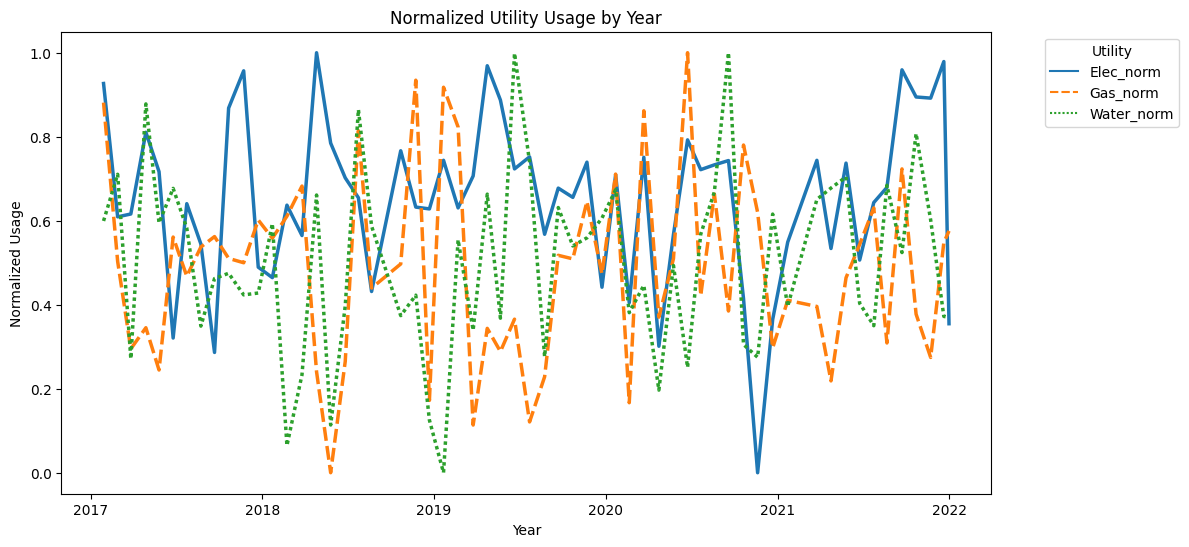

In [30]:
plot_utils(ts_lin)

In [31]:
# Function that plots the utility data separately
def plot_utils_sep(df):

    plt.figure(figsize=(12, 6))

    # Plot for Electricity Usage
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Electricity_Usage_kWh'], label='Electricity Usage (kWh)', color='green', linewidth=2.5)
    plt.title('Electricity Usage by Year')
    plt.xlabel('Year')
    plt.ylabel('Electricity Usage (kWh)')

    # Plot for Gas Usage
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['Gas_Usage_Therms'], label='Gas Usage (Therms)', color='red', linewidth=2.5)
    plt.title('Gas Usage by Year')
    plt.xlabel('Year')
    plt.ylabel('Gas Usage (Therms)')

    # Plot for Water Usage
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['Water_Usage_Gallons'], label='Water Usage (Gallons)', color='blue', linewidth=2.5)
    plt.title('Water Usage by Year')
    plt.xlabel('Year')
    plt.ylabel('Water Usage (Gallons)')

    plt.tight_layout()
    plt.show()

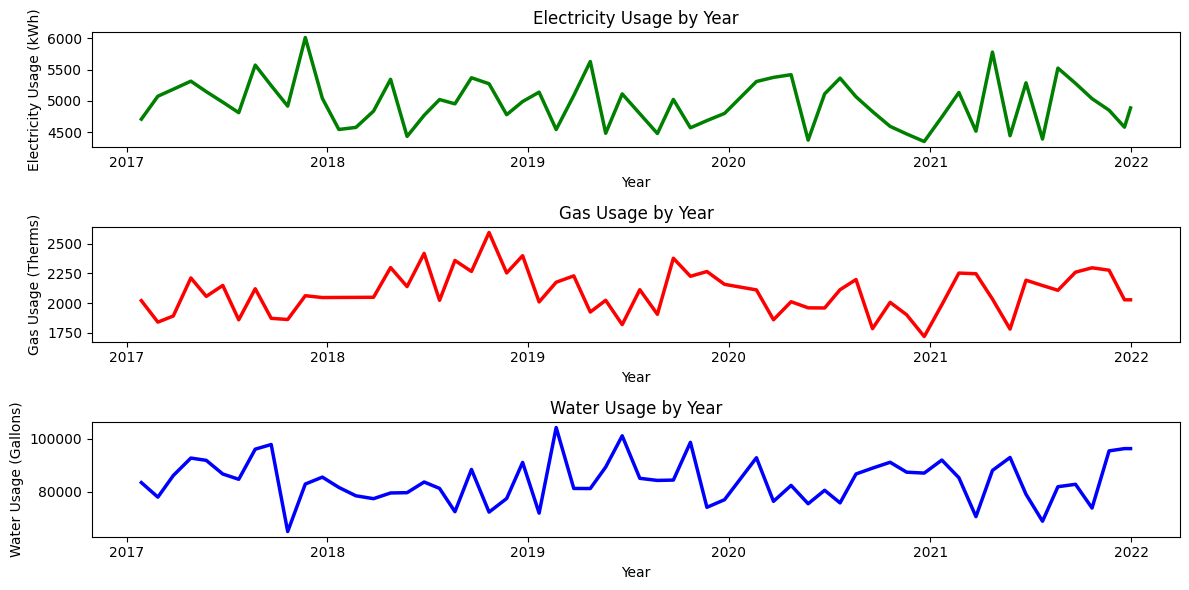

In [32]:
plot_utils_sep(ts_exp)

In [33]:
# Function that plots stacked yearly Gas Usage
def plot_stack_year(ts):
    # Extract year and month for grouping
    ts['Year'] = ts['Start_Date'].dt.year
    ts['Month'] = ts['Start_Date'].dt.month

    # Grouping data by month and then by year
    grouped_data = ts.groupby(['Month', 'Year'])['Gas_Usage_Therms'].mean().unstack()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped_data, linewidth=2.5)

    plt.title('Monthly Gas Usage Over Different Years')
    plt.xlabel('Month')
    plt.ylabel('Gas Usage [Therms]')
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.show()

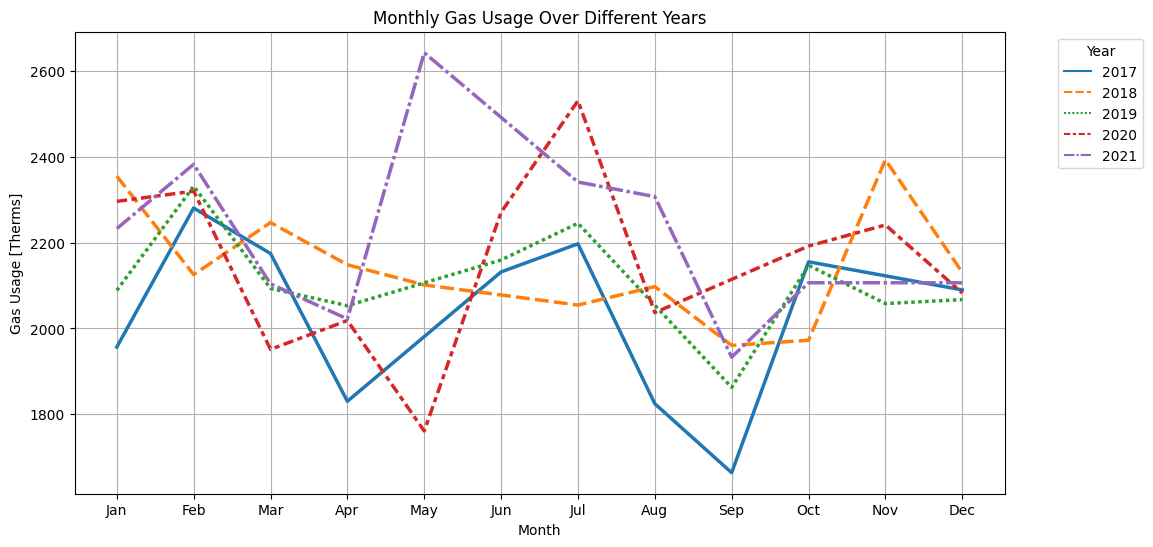

In [34]:
plot_stack_year(ts_shu)

Out of the three utilities used, Gas [Therms] could most closely be associated with seasonality. While none of the utilities look like they operate on any trend or seasonal pattern, I will double check with Auto-Correllation Function.

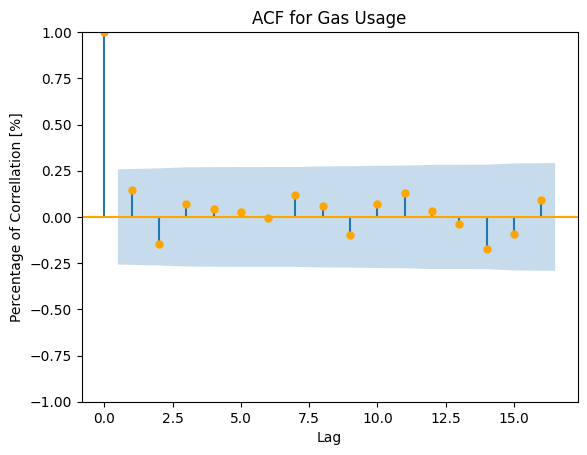

In [35]:
# Plotting ACF for seasonal trends in Gas Usage
plot_acf(ts_shu['Gas_Usage_Therms'], lags=16, title='ACF for Gas Usage', color='orange')
plt.xlabel('Lag')
plt.ylabel('Percentage of Correllation [%]')
plt.show()

From the graph, we can see that the ACF for Gas Usage doesn't show any seasonality to it. None on the offsets correlate past 25%. We can confidently say that if there is seasonality to the Gas Usage, it is negated by other external factors.

# 5. Communication

## Introduction

This report summarizes the analysis conducted on energy consumption data from seven units across two properties. The focus was on identifying any patterns or trends that could inform energy efficiency strategies.


## Methodology
My analysis followed these steps:

Data Cleaning and Validation: Energy consumption data was gathered for each unit, ensuring accuracy and consistency.

Data Normalization: Normalized energy consumption values

Energy Conversion: Energy consumption was converted into c02 emissions per metric ton.

Calculation of Average Emissisions by Unit and Property: Analysis was done to highlight companies and buildings which had higher than average c02 emissions per square foot.

Data Viusalizations/ Trend and Seasonality Analysis: The data was examined for linear trends, indicative of long-term changes in energy usage. An Autocorrelation Function (ACF) was utilized to evaluate the seasonality in energy consumption, particularly for gas usage.


## Observations

Consistency in Energy Usage: The data analysis didn’t point to any significant linear or seasonal trends in energy consumption across the units. Specifically, the ACF analysis for gas usage didn’t show any strong correlations indicative of seasonality, suggesting that other external factors might be mitigating potential seasonal influences.

Comparison of Emission Efficiency: An interesting finding was that the Empire State Building, even post its 2010 retrofit, registered higher average emissions per square foot in comparison to the more modern World Trade Center. This discrepancy highlights the potential for more advanced retrofitting initiatives.

## Issues Identified

Incomplete Data: There were gaps in the data collection, which could impact the accuracy and comprehensiveness of the analysis.

Inconsistent Data Reporting: Some conflicting values were noted in data reporting, from sources like LinkedIn and Condé Nast.


## Recommendations

Targeted Retrofitting for Enhanced Efficiency: Considering the higher emission rates of the Empire State Building, it’s advisable to plan for additional retrofitting, focusing on incorporating cutting-edge sustainability features to boost energy efficiency.

Refinement of Data Collection Methods: We need to bolster our data collection methods to fill in any gaps and ensure uniformity in data reporting. This would involve, for instance, ensuring that sources like LinkedIn and Condé Nast deliver one consistent utility data point every 28 days.


## Conclusion

My analysis indicates consistent energy consumption patterns across the evaluated units, with a notable disparity in emission efficiency between older and newer buildings. Addressing the identified data issues and implementing the recommended strategies can significantly enhance energy efficiency and sustainability, aligning with environmental standards and reducing operational costs. The Cambio customer success team should prioritize these actions to optimize energy management in their properties. ​​